<a href="https://colab.research.google.com/github/vinalyan/diff/blob/master/GeekBrains/algorithms/web4/Lession_4_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Настройки
Тут все настройки необходимые для работы по домашнему заданию

In [478]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Практически все ниже из материалов лекции

In [479]:
# сгенерируем данные 
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=8, n_samples = 300)

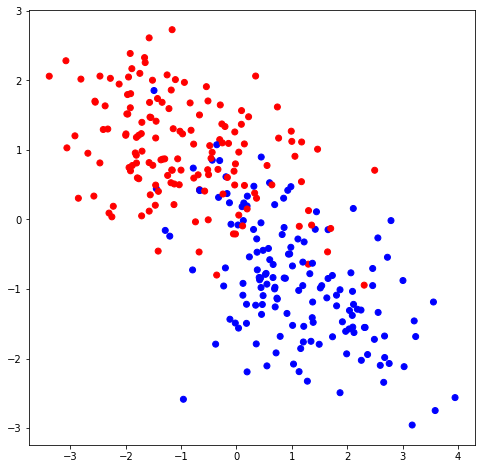

In [480]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [481]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [482]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [483]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [484]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [485]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [486]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)           
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

***Тут начались правки***

In [487]:

#Подсчет количества листов в ноде
def leafs_count(node):
    ls = 0
    if isinstance(node, Leaf):
        ls = ls + 1
        return ls
    ls = ls + leafs_count(node.true_branch) 
    ls = ls + leafs_count(node.false_branch)
    return ls

In [476]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, el_count, leafs):

    gain, t, index = find_best_split(data, labels)

    #"ТУТ ДОБАВЛЕНО"
    #Если возможно создать меньше двух лстов, то останавливаем дерелени
    if leafs < 2:
      return Leaf(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
      return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    #Если в результате разбиения количесто элементов меньше требуемого для листа, то новая ветка не генерится
    if true_data.shape[0] <= el_count or false_data.shape[0] <= el_count: 
      return Leaf(data, labels)
    
    # Рекурсивно строим два поддерева 
    # Резервируем один элемент для False ветки, на случай, если все все литы съест Trut ветка
    true_branch = build_tree(true_data, true_labels, el_count, leafs - 1)

    #уменьшаем количество доступных листов узла на количество листов в true ветке 
    leafs = leafs - leafs_count(true_branch)

    false_branch = build_tree(false_data, false_labels, el_count, leafs)
   
    #уменьшаем количество доступных листов узла на количество листов в false ветке 
    leafs = leafs - leafs_count(false_branch)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева

    return Node(index, t, true_branch, false_branch)

In [488]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [489]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [490]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [491]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=''):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '> True:')
    print_tree(node.true_branch, spacing + "-")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '> False:')
    print_tree(node.false_branch, spacing + "-")
    

# Задание №1

В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)



Реализовал критерий останова по минимальному количеству элементов в листе и количеству листов.
Для этого доработал функцию `build_tree`
1. ввел параметр `el_count` характеризующий минимальное количество элементов в листе
2. добавил проверку количетсва обрататываемых элементов
3. ввел параметр `leafs`, характеризующий количество листов
4. добавил функцию `leafs_count` для подсчета количества листов
5. добавил проверку количества листов в ноде. На каждую следующую ноду количество листов уменьшается. Не уверен, что я сделал верно



In [492]:
# Построим дерево по обучающей выборке
my_tree_1 = build_tree(train_data, train_labels, 1, leafs = 8)
print_tree(my_tree_1)
leafs_count(my_tree_1)

Индекс 1 <= -0.141661458578085
> True:
-Индекс 0 <= -0.018630610158921423
-> True:
--Индекс 1 <= -0.9569842761342535
--> True:
---Прогноз: 1
--> False:
---Прогноз: 0
-> False:
--Прогноз: 1
> False:
-Индекс 1 <= 0.4438395953160996
-> True:
--Индекс 0 <= -0.6685578007404154
--> True:
---Прогноз: 0
--> False:
---Индекс 1 <= 0.15117421125794617
---> True:
----Прогноз: 0
---> False:
----Индекс 1 <= 0.23723026276764592
----> True:
-----Прогноз: 1
----> False:
-----Прогноз: 1
-> False:
--Прогноз: 0


8

In [493]:
my_tree_2 = build_tree(train_data, train_labels, 10, leafs = 5)
print_tree(my_tree_2)
leafs_count(my_tree_2)

Индекс 1 <= -0.141661458578085
> True:
-Индекс 0 <= -0.018630610158921423
-> True:
--Прогноз: 1
-> False:
--Прогноз: 1
> False:
-Индекс 1 <= 0.4438395953160996
-> True:
--Прогноз: 0
-> False:
--Индекс 0 <= -0.8211834587029929
--> True:
---Прогноз: 0
--> False:
---Прогноз: 0


5

In [494]:
# Получим ответы для обучающей выборки 
train_answers_1 = predict(train_data, my_tree_1)
train_answers_2 = predict(train_data, my_tree_2)

In [472]:
# И получим ответы для тестовой выборки
answers_1 = predict(test_data, my_tree_1)
answers_2 = predict(test_data, my_tree_2)


In [495]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [496]:
print('my_tree_1')
print(f'Точность на обучающей выборке : {accuracy_metric(train_labels, train_answers_1)}')
print(f'Точность на тестовой выборке : {accuracy_metric(test_labels, answers_1)}')
print('my_tree_2')
print(f'Точность на обучающей выборке : {accuracy_metric(train_labels, train_answers_2)}')
print(f'Точность на тестовой выборке : {accuracy_metric(test_labels, answers_2)}')


my_tree_1
Точность на обучающей выборке : 91.42857142857143
Точность на тестовой выборке : 87.77777777777777
my_tree_2
Точность на обучающей выборке : 87.61904761904762
Точность на тестовой выборке : 85.55555555555556


# *Задание №2 
Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.



In [ ]:
# Rласс терминального узла (листа для регресса)

class Leaf_R:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.mean = self.mean()

    #-------ЗАМЕНА----------- 
    def mean(self):
        return self.data.mean()   
    #------КОНЕЦ ЗАМЕНЫ--------     

Тут, к сожалению не успеваю, доделаю потом. Когда-нибудь